Copyright (c) Microsoft Corporation. All rights reserved.  
Licensed under the MIT License.

# Inference PyTorch Bert Model for High Performance in ONNX Runtime

In this tutorial, you'll be introduced to how to load a Bert model from PyTorch, convert it to ONNX, and inference it for high performance using ONNX Runtime. In the following sections, we are going to use the Bert model trained with Stanford Question Answering Dataset (SQuAD) dataset as an example. Bert SQuAD model is used in question answering scenarios, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.

## 0. Prerequisites ##
It need a python environment with [PyTorch](https://pytorch.org/) and [OnnxRuntime](https://microsoft.github.io/onnxruntime/) installed before running this notebook. 

First, we install [AnaConda](https://www.anaconda.com/distribution/) in a target machine and open an AnaConda prompt window when it is done. Then you can choose a setup based on your target device (CPU or GPU), and run the commands to create a conda environment.

#### CPU Environment Setup
If your machines does not have GPU or want to test CPU inference. You can create a conda environment like the following:

```console
conda create -n cpu_env python=3.6
conda activate cpu_env
conda install pytorch torchvision cpuonly -c pytorch
pip install onnxruntime
conda install jupyter
jupyter notebook
```
The last command will launch Jupyter Notebook and we can open this notebook in browser to continue.

Another option is to use pip to install package to your existing jupyter notebook environment:
```console
pip install --upgrade torch==1.4.0+cpu torchvision==0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
pip install onnxruntime==1.1.2
```

#### GPU Environment Setup

This requires your machine to have a GPU.

```console
conda create -n gpu_env python=3.6
conda activate gpu_env
conda install pytorch torchvision cudatoolkit=10.1 -c pytorch
pip install onnxruntime-gpu
conda install jupyter
jupyter notebook
```

onnxruntime-gpu v1.1.2 requires installing [CUDA](https://developer.nvidia.com/cuda-downloads) 10.0 and [cuDNN](https://developer.nvidia.com/cudnn) 7.6, and add their bin directories to PATH environment variable (You need update the path in section 4 below).

In [1]:
# install some packages used in this notebook
import sys
!{sys.executable} -m pip install --upgrade torch==1.4.0+cpu torchvision==0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
!{sys.executable} -m pip install onnxruntime==1.1.2
!{sys.executable} -m pip install transformers==2.5.1
!{sys.executable} -m pip install wget psutil onnx pytz pandas py-cpuinfo py3nvml

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.4.0+cpu in d:\anaconda3\envs\cpu_env\lib\site-packages (1.4.0+cpu)
Requirement already up-to-date: torchvision==0.5.0+cpu in d:\anaconda3\envs\cpu_env\lib\site-packages (0.5.0+cpu)


## 1. Load Pretrained Bert model ##

We begin by downloading the data files and store them in the specified location. 

In [2]:
import os

cache_dir = "./squad"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

predict_file_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json"
predict_file = os.path.join(cache_dir, "dev-v1.1.json")
if not os.path.exists(predict_file):
    import wget
    print("Start downloading predict file.")
    wget.download(predict_file_url, predict_file)
    print("Predict file downloaded.")

Specify some model config variables.

In [3]:
# For fine tuned large model, the model name is "bert-large-uncased-whole-word-masking-finetuned-squad". Here we use bert-base for demo.
model_name_or_path = "bert-base-cased"
max_seq_length = 128
doc_stride = 128
max_query_length = 64
# enable overwrite to export onnx model and download latest script each time when running this notebook.
enable_overwrite = False
# total samples to inference, so that we can get average latency
total_samples = 100

Start to load model from pretrained. This step could take a few minutes. 

In [4]:
# The following code is adapted from HuggingFace transformers
# https://github.com/huggingface/transformers/blob/master/examples/run_squad.py

from transformers import (BertConfig, BertForQuestionAnswering, BertTokenizer)

# Load pretrained model and tokenizer
config_class, model_class, tokenizer_class = (BertConfig, BertForQuestionAnswering, BertTokenizer)
config = config_class.from_pretrained(model_name_or_path, cache_dir=cache_dir)
tokenizer = tokenizer_class.from_pretrained(model_name_or_path, do_lower_case=True, cache_dir=cache_dir)
model = model_class.from_pretrained(model_name_or_path,
                                    from_tf=False,
                                    config=config,
                                    cache_dir=cache_dir)
# load some examples
from transformers.data.processors.squad import SquadV1Processor

processor = SquadV1Processor()
examples = processor.get_dev_examples(None, filename=predict_file)

from transformers import squad_convert_examples_to_features
features, dataset = squad_convert_examples_to_features( 
            examples=examples[:total_samples], # convert just enough examples for this notebook
            tokenizer=tokenizer,
            max_seq_length=max_seq_length,
            doc_stride=doc_stride,
            max_query_length=max_query_length,
            is_training=False,
            return_dataset='pt'
        )

add example index and unique id: 100%|███████████████████████████████████████████████████████| 100/100 [00:00<?, ?it/s]


## 2. Export the loaded model ##
Once the model is loaded, we can export the loaded PyTorch model to ONNX.

In [5]:
output_dir = "./onnx"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)   
export_model_path = os.path.join(output_dir, 'bert-base-cased-squad.onnx')

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the first example data to run the model and export it to ONNX
data = dataset[0]
inputs = {
    'input_ids':      data[0].to(device).reshape(1, max_seq_length),
    'attention_mask': data[1].to(device).reshape(1, max_seq_length),
    'token_type_ids': data[2].to(device).reshape(1, max_seq_length)
}

# Set model to inference mode, which is required before exporting the model because some operators behave differently in 
# inference and training mode.
model.eval()
model.to(device)

if enable_overwrite or not os.path.exists(export_model_path):
    with torch.no_grad():
        symbolic_names = {0: 'batch_size', 1: 'max_seq_len'}
        torch.onnx.export(model,                                            # model being run
                          (inputs['input_ids'],                             # model input (or a tuple for multiple inputs)
                           inputs['attention_mask'], 
                           inputs['token_type_ids']), 
                          export_model_path,                                # where to save the model (can be a file or file-like object)
                          opset_version=11,                                 # the ONNX version to export the model to
                          do_constant_folding=True,                         # whether to execute constant folding for optimization
                          input_names=['input_ids',                         # the model's input names
                                       'input_mask', 
                                       'segment_ids'],
                          output_names=['start', 'end'],                    # the model's output names
                          dynamic_axes={'input_ids': symbolic_names,        # variable length axes
                                        'input_mask' : symbolic_names,
                                        'segment_ids' : symbolic_names,
                                        'start' : symbolic_names,
                                        'end' : symbolic_names})
        print("Model exported at ", export_model_path)

## 3. PyTorch Inference ##
Use PyTorch to evaluate an example input for comparison purpose.

In [6]:
import time

# Measure the latency. It is not accurate using Jupyter Notebook, it is recommended to use standalone python script.
latency = []
with torch.no_grad():
    for i in range(total_samples):
        data = dataset[i]
        inputs = {
            'input_ids':      data[0].to(device).reshape(1, max_seq_length),
            'attention_mask': data[1].to(device).reshape(1, max_seq_length),
            'token_type_ids': data[2].to(device).reshape(1, max_seq_length)
        }
        start = time.time()
        outputs = model(**inputs)
        latency.append(time.time() - start)
print("PyTorch {} Inference time = {} ms".format(device.type, format(sum(latency) * 1000 / len(latency), '.2f')))

PyTorch cpu Inference time = 140.94 ms


## 4. Inference the Exported Model with ONNX Runtime ##

To use onnxruntime-gpu, it is required to install CUDA 10.0 and CUDNN 7.6, and add their bin directories to PATH environment variable.

In [7]:
use_gpu = (device.type == 'cuda')
if use_gpu:
    # Add path for CUDA 10.0 and CUDNN 7.6, which are required by onnxruntime-gpu
    cuda_dir = 'D:/NVidia/CUDA/v10.0/bin'
    cudnn_dir = 'D:/NVidia/CUDA/v10.0/bin'
    if not (os.path.exists(cuda_dir) and os.path.exists(cudnn_dir)):
        raise ValueError("Please specify correct path for CUDA 10.0 and CUDNN 7.6. Otherwise onnxruntime-gpu cannot be imported.")
    else:
        if cuda_dir == cudnn_dir:
            os.environ["PATH"] = cuda_dir + ';' + os.environ["PATH"]
        else:
            os.environ["PATH"] = cuda_dir + ';' + cudnn_dir + ';' + os.environ["PATH"]

Now we are ready to inference the model with ONNX Runtime.

In [8]:
import psutil
import onnxruntime
import numpy

device_name = 'cuda' if 'CUDAExecutionProvider' in onnxruntime.get_available_providers() else 'cpu'
if use_gpu:
    assert device_name == "cuda"
   
sess_options = onnxruntime.SessionOptions()

# Optional: store the optimized graph and view it using Netron to verify that model is fully optimized.
# Note that this will increase session creation time so enable it for debugging only.
# sess_options.optimized_model_filepath = os.path.join(output_dir, "optimized_model_{}.onnx".format(device_name))
   
if not use_gpu:
    # The following settings enables OpenMP, which is required to get best performance for CPU inference of Bert models.
    sess_options.intra_op_num_threads=1
    os.environ["OMP_NUM_THREADS"] = str(psutil.cpu_count(logical=True))
    os.environ["OMP_WAIT_POLICY"] = 'ACTIVE'    
else:
    # onnxruntim-gpu is not built with OpenMP so no need to set OMP envirnoment variable
    sess_options.intra_op_num_threads=psutil.cpu_count(logical=False)

session = onnxruntime.InferenceSession(export_model_path, sess_options)

latency = []
for i in range(total_samples):
    data = dataset[i]
    # Use contiguous array as input might improve performance
    ort_inputs = {
        'input_ids':  numpy.ascontiguousarray(data[0].cpu().reshape(1, max_seq_length).numpy()),
        'input_mask': numpy.ascontiguousarray(data[1].cpu().reshape(1, max_seq_length).numpy()),
        'segment_ids': numpy.ascontiguousarray(data[2].cpu().reshape(1, max_seq_length).numpy())
    }
    start = time.time()
    ort_outputs = session.run(None, ort_inputs)
    latency.append(time.time() - start)
print("OnnxRuntime {} Inference time = {} ms".format(device_name, format(sum(latency) * 1000 / len(latency), '.2f')))

OnnxRuntime cpu Inference time = 124.13 ms


In [9]:
print("***** Verifying correctness *****")
for i in range(2):
    print('PyTorch and ONNX Runtime output {} are close:'.format(i), numpy.allclose(ort_outputs[i], outputs[i].cpu(), rtol=1e-05, atol=1e-04))

***** Verifying correctness *****
PyTorch and ONNX Runtime output 0 are close: False
PyTorch and ONNX Runtime output 1 are close: False


### Inference with Actual Sequence Length
Note that ONNX model is exported using dynamic length axis. A simple trick for better performance is to dynamic length input instead of fixed length input. Let's see how it can be applied to this model.

**Note**: Need evaluate the end-to-end impact on performance and accuracy if you use this strategy. It could be a good trade off for some senario.

In [10]:
# An example input (we can see padding). From attention_mask, we can deduce the actual length.
inputs

{'input_ids': tensor([[  101,  1150,  1108,  1103,  1211,  7468,  1591,  1111,  1103,  1410,
            183,  2087,  1233,  1265,   136,   102, 23975, 17803,  1116,   117,
           1105,  7172,  2145, 16854,  3649,  1468,  1112,  1141,  1104,  1300,
           1929,  1115,  1138,  1189,  2022,  3178,  1107,  1103,  7688,  7329,
            119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,    

In [11]:
import statistics
opt_session = onnxruntime.InferenceSession(export_model_path, sess_options)

latency = []
lengths = []
for i in range(total_samples):
    data = dataset[i]
    # Instead of using fixed length (128), we can use actual sequence length (less than 128), which helps to get better performance.
    actual_sequence_length = sum(data[1].numpy())
    lengths.append(actual_sequence_length)
    ort_inputs = {
        'input_ids':  data[0].numpy()[:actual_sequence_length].reshape(1, actual_sequence_length),
        'input_mask': data[1].numpy()[:actual_sequence_length].reshape(1, actual_sequence_length),
        'segment_ids': data[2].numpy()[:actual_sequence_length].reshape(1, actual_sequence_length)
    }
    start = time.time()
    opt_outputs = session.run(None, ort_inputs)
    latency.append(time.time() - start)
print("Average length", statistics.mean(lengths))
print("OnnxRuntime {} Inference time with actual sequence length = {} ms".format(device_name, format(sum(latency) * 1000 / len(latency), '.2f')))

Average length 96
OnnxRuntime cpu Inference time with actual sequence length = 93.86 ms


In [12]:
print("***** Verifying correctness for using actual sequence length *****")
for i in range(2):
    print('PyTorch and ONNX Runtime output {} are close:'.format(i), numpy.allclose(opt_outputs[i], outputs[i].cpu()[:,:len(opt_outputs[i][0])], rtol=1e-05, atol=1e-04))

***** Verifying correctness for using actual sequence length *****
PyTorch and ONNX Runtime output 0 are close: False
PyTorch and ONNX Runtime output 1 are close: False


### 5. Offline Optimization Script and Test Tools
For better control of optimization, accuracy & performance tests, it is recommended to download the [OnnxRuntime Python Tools for BERT](https://github.com/microsoft/onnxruntime/tree/master/onnxruntime/python/tools/bert), and try them on the exported ONNX models.

You may copy the whole [directory](https://github.com/microsoft/onnxruntime/tree/master/onnxruntime/python/tools/bert) to a sub-directory named bert_scripts. Here is list of script files needed at the time this notebook is created, and the list might need update when you run the notebook by yourself.

In [13]:
import os
import wget
url_prfix = "https://raw.githubusercontent.com/microsoft/onnxruntime/master/onnxruntime/python/tools/bert/"
script_files = ['bert_perf_test.py', 'bert_test_data.py', 'compare_bert_results.py', 'BertOnnxModel.py', 'BertOnnxModelKeras.py', 'BertOnnxModelTF.py', 'OnnxModel.py', 'bert_model_optimization.py']

script_dir = './bert_scripts'
if not os.path.exists(script_dir):
    os.makedirs(script_dir)

for filename in script_files:
    target_file = os.path.join(script_dir, filename)
    if enable_overwrite and os.path.exists(target_file):
        os.remove(target_file)
    if not os.path.exists(target_file):
        wget.download(url_prfix + filename, target_file)
        print("Downloaded", filename)

#### BERT Optimization Script

Although OnnxRuntime could optimize Bert model exported by PyTorch. Sometime, model cannot be fully optimized due to different reasons:
* A new subgraph pattern is generated by training and export tool, and the pattern is not covered by released onnxruntime.
* The exported model uses dynamic axis and this makes it harder for shape inference of the graph. That blocks some optimization to be applied.
* Some optimization is better to be done offline. Like change input tensor type from int64 to int32 to avoid extra Cast nodes, or convert model to float16 to achieve better performance in V100 or T4 GPU.

We have python script **bert_model_optimization.py**, which is more flexible in graph pattern matching and model conversion (like float32 to float16). You can also use it to verify whether a Bert model is fully optimized.

In this example, we can see that it introduces more optimizations that is not provided by onnxruntime: (1) Gelu from PyTorch 1.4 is not fused by OnnxRuntime 1.1.2 (2) SkipLayerNormalization and bias fusion, which is not fused in OnnxRuntime due to shape inference as mentioned.

It will also tell whether the model is fully optimized or not. If not, that means you might need change the script a little to fuse some new patern of subgraph.

In [14]:
GPU_OPTION = '--gpu_only' if use_gpu else ''
optimized_model_path = './onnx/bert-base-cased-squad_opt_{}.onnx'.format('gpu' if use_gpu else 'cpu')
%run ./bert_scripts/bert_model_optimization.py --input $export_model_path --output $optimized_model_path $GPU_OPTION

bert_model_optimization.py: Save optimized model by onnxruntime to ./onnx\bert-base-cased-squad_ort_cpu.onnx
bert_model_optimization.py: Use OnnxRuntime to optimize and save the optimized model to ./onnx\bert-base-cased-squad_ort_cpu.onnx
    BertOnnxModel.py: Fused LayerNormalization count: 0
    BertOnnxModel.py: Fused Gelu count:12
    BertOnnxModel.py: Fused Reshape count:0
    BertOnnxModel.py: Fused SkipLayerNormalization count: 24
    BertOnnxModel.py: Fused Attention count:0
    BertOnnxModel.py: skip embed layer fusion since mask input is not found
    BertOnnxModel.py: Fused SkipLayerNormalization with Bias count:24
    BertOnnxModel.py: opset verion: 11
        OnnxModel.py: Output model to ./onnx/bert-base-cased-squad_opt_cpu.onnx
    BertOnnxModel.py: EmbedLayer=1, Attention=12, Gelu=12, LayerNormalization=24, Succesful=True
bert_model_optimization.py: The output model is fully optimized.


#### Optimized Graph
Run the next step, we will open the optimized model using Netron to visualize. The graph is like the following:
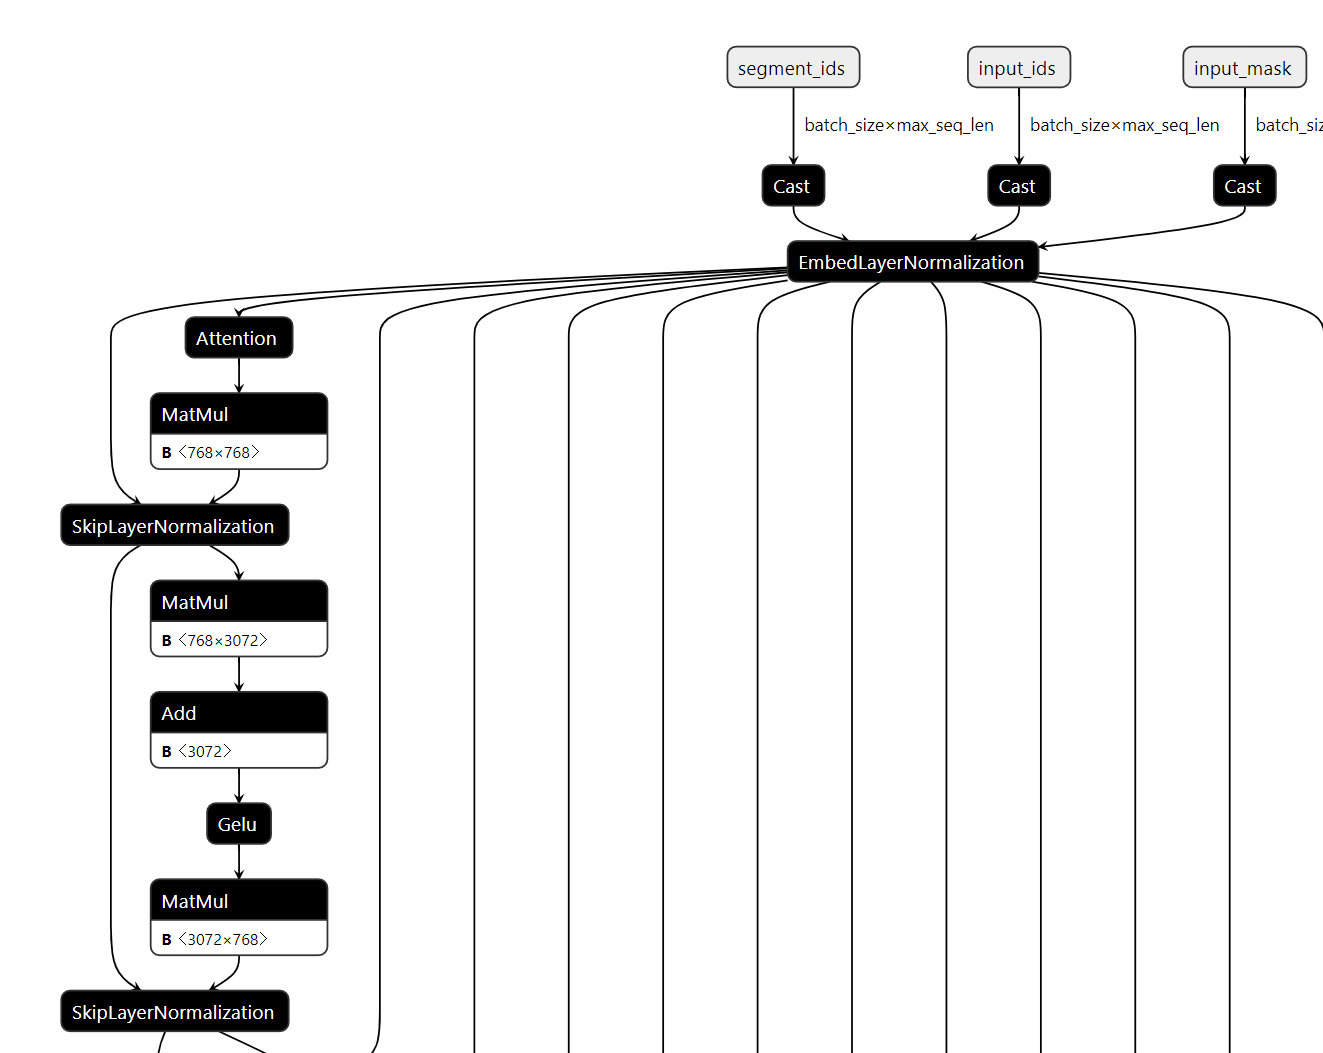

Sometime, optimized graph is slightly different: for example, Add and Gelu is fused into BiasGelu (for CPU) or FastGelu (for GPU).

In [15]:
!{sys.executable} -m pip install netron
import netron
netron.start(optimized_model_path)

Serving './onnx/bert-base-cased-squad_opt_cpu.onnx' at http://localhost:8080


#### Performance Test Tool

The following will create 100 samples (of batch_size 1 and sequence length 128), then get the average latency and throughput numbers. You can increase number of samples (recommendation is 1000 samples) to get more stable result.

In [16]:
GPU_OPTION = '--use_gpu' if use_gpu else ''

%run ./bert_scripts/bert_perf_test.py --model $optimized_model_path --batch_size 1 --sequence_length 128 --samples 100 --test_times 1 --inclusive --all $GPU_OPTION

generating test data...
Running test: model=bert-base-cased-squad_opt_cpu.onnx,graph_optimization_level=ENABLE_ALL,intra_op_num_threads=12,OMP_NUM_THREADS=1,OMP_WAIT_POLICY=ACTIVE,batch_size=1,sequence_length=128,test_cases=100,test_times=1,contiguous=False,use_gpu=False
Average latency is 151.21 ms
Running test: model=bert-base-cased-squad_opt_cpu.onnx,graph_optimization_level=ENABLE_ALL,intra_op_num_threads=1,OMP_NUM_THREADS=12,OMP_WAIT_POLICY=ACTIVE,batch_size=1,sequence_length=128,test_cases=100,test_times=1,contiguous=False,use_gpu=False
Average latency is 116.25 ms
Running test: model=bert-base-cased-squad_opt_cpu.onnx,graph_optimization_level=ENABLE_ALL,intra_op_num_threads=1,OMP_NUM_THREADS=12,OMP_WAIT_POLICY=PASSIVE,batch_size=1,sequence_length=128,test_cases=100,test_times=1,contiguous=False,use_gpu=False
Average latency is 108.56 ms
Running test: model=bert-base-cased-squad_opt_cpu.onnx,graph_optimization_level=ENABLE_ALL,intra_op_num_threads=1,OMP_NUM_THREADS=6,OMP_WAIT_POL

Let's loaded the summary file and take a look.

In [17]:
import os
import glob     
import pandas
latest_result_file = max(glob.glob("./onnx/perf_results_*.txt"), key=os.path.getmtime)
result_data = pandas.read_table(latest_result_file)
print(latest_result_file)
sorted_result = result_data.sort_values(by='Latency(ms)', ascending=True)
# Remove some columns that have same values for all rows.
sorted_result.drop(['model', 'graph_optimization_level', 'batch_size', 'sequence_length', 'test_cases', 'test_times', 'use_gpu'], axis=1, inplace=True)
sorted_result

./onnx\perf_results_CPU_B1_S128_20200306-014317.txt


,Latency(ms),Throughput(QPS),intra_op_num_threads,OMP_NUM_THREADS,OMP_WAIT_POLICY,contiguous
9,88.98,11.24,1,6,PASSIVE,True
4,94.00,10.64,1,6,PASSIVE,False
7,94.52,10.58,1,12,PASSIVE,True
6,100.20,9.98,1,12,ACTIVE,True
8,101.02,9.90,1,6,ACTIVE,True
3,104.28,9.59,1,6,ACTIVE,False
2,108.56,9.21,1,12,PASSIVE,False
1,116.25,8.60,1,12,ACTIVE,False
5,127.16,7.86,12,1,ACTIVE,True
0,151.21,6.61,12,1,ACTIVE,False


When a BERT model is optimized, some approximation is used in calculation. If your BERT model has three inputs, a script compare_bert_results.py can be used to do a quick verification. The tool will generate some fake input data, and compare results from both the original and optimized models. If outputs are all close, it is safe to use the optimized model.

Example of verifying models:

In [18]:
%run ./bert_scripts/compare_bert_results.py --baseline_model $export_model_path --optimized_model $optimized_model_path --batch_size 1 --sequence_length 128 --samples 100 $GPU_OPTION

100% passed for 100 random inputs given thresholds (rtol=0.001, atol=0.0001).
maximum absolute difference=1.2487173080444336e-05
maximum relative difference=0.001609674422070384


Here is the machine configuration that generated the above results. The machine has GPU but not used in CPU inference.
You might get slower or faster result based on your hardware.

In [19]:
%run ./bert_scripts/machine_info.py

{
  "gpu": {
    "driver_version": "441.22",
    "devices": [
      {
        "memory_total": 8589934592,
        "memory_available": 5773070336,
        "name": "GeForce GTX 1070"
      }
    ]
  },
  "cpu": {
    "brand": "Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz",
    "cores": 6,
    "logical_cores": 12,
    "hz": "3.1920 GHz",
    "l2_cache_size": "1536 KB",
    "l3_cache_size": "12288 KB",
    "processor": "Intel64 Family 6 Model 158 Stepping 10, GenuineIntel"
  },
  "memory": {
    "total": 16971259904,
    "available": 3713355776
  },
  "python": "3.6.10.final.0 (64 bit)",
  "os": "Windows-10-10.0.18362-SP0"
}
